In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.markers import TICKDOWN
import matplotlib
import datetime
from scipy.stats import norm
import imageio
from matplotlib.gridspec import GridSpec

from lib.analysis.laminar_dist import Line

# based on reference http://www.georgemather.com/Model.html#Refs

In [2]:
# an object moving in circles?
stim_type = ['circular_point',  # 0
             'single_pulse',    # 1
             'translating_bar', # 2
             'circular_edge',   # 3
             'double_pulse',    # 4
             'two_circular_points',][5]   # 5

In [3]:
# intralaminar PV velocities over barrels of size 100-300 um
barrel_latency_PV = 200 / 57  # ms
barrel_latency_PV_se = 100 / 41
# Katherine S Scheuer, John M Judge, Xinyu Zhao, Meyer B Jackson, Velocity of conduction between columns and layers in barrel cortex reported by parvalbumin interneurons, Cerebral Cortex 33:17, 1 Sept 2023, p 9917–9926
print(barrel_latency_PV, barrel_latency_PV_se)

3.508771929824561 2.4390243902439024


In [4]:
barrel_latency_PV_excitatory_L4 = 1.028032
barrel_latency_PV_excitatory_L4_se = 1.0011922707332492

In [5]:
# Barrel cortex motion
# from http://www.georgemather.com/Model.html#Refs

# Define the space axis of the filters
nx_row = 8
ny_arc = 5
max_x = 0.2  # Half-width of filter (deg)
max_y = 0.2
dx = (max_x * 2) / nx_row  # Spatial sampling interval of filter (deg)
dy = (max_y * 2) / ny_arc

# A row vector holding spatial sampling intervals
x_filt = np.linspace(-max_x, max_x, nx_row)
y_filt = np.linspace(-max_y, max_y, ny_arc)

# Spatial filter parameters
sx = 0.05 # standard deviation of Gaussian, in deg.
sfx = 0.11 # spatial frequency of carrier, in cpd
sy = 0.05 # standard deviation of Gaussian, in deg.
sfy = 0.11 # spatial frequency of carrier, in cpd

# Spatial filter response
gauss_x = np.exp(-x_filt ** 2 / sx ** 2)  # Gaussian envelope
even_x = np.cos(2 * np.pi * sfx * x_filt) * gauss_x  # Even Gabor
odd_x = np.sin(2 * np.pi * sfx * x_filt) * gauss_x  # Odd Gabor
gauss_y = np.exp(-y_filt ** 2 / sy ** 2)  # Gaussian envelope
even_y = np.cos(2 * np.pi * sfy * y_filt) * gauss_y  # Even Gabor
odd_y = np.sin(2 * np.pi * sfy * y_filt) * gauss_y  # Odd Gabor

In [6]:
# Define the time axis of the filters
nt = 100  # number temporal samples in the filter
max_t = 0.05  # Duration of impulse response (sec)
dt = max_t / nt  #Temporal sampling interval (sec)

# temporal sampling intervals
t_filt = np.linspace(0, max_t, nt)

# Temporal filter parameters
k = 100 # Scales the response into time units
slow_n = 30 # Width of the slow temporal filter
fast_n = 15 # Width of the fast temporal filter
beta = 0.9 # Weighting of  -ve phase of the temporal resp relative to +ve phase.

# Temporal filter response
slow_t = (k * t_filt) ** slow_n * np.exp(-k * t_filt) * (1 / np.math.factorial(slow_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(slow_n + 2))
fast_t = (k * t_filt) ** fast_n * np.exp(-k * t_filt) * (1 / np.math.factorial(fast_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(fast_n + 2))

# To reflect casuality, have to reflect temporal component across t = 0
slow_t = np.flip(slow_t)
fast_t = np.flip(fast_t)

In [7]:
# spatiotemporal filters
# need all 2 x 2 x 2 = 8 combinations of t, x, y filters
# The orientation is controlled by the coupling of even and odd spatial functions
# Note that :
#       - Even is slightly more influential than odd function
#       - Fast function is slightly more influential than slow function
#       - "odd" is positive to the right first, and negative to the immediate left
#                Then in a few milliseconds, this switches.

# As an example, consider left_1 = o_fast + e_slow
#    Odd filter responds positively to signal that is high at the right
#    first, then high at the left next -- which is left-moving signal.
#    e_slow is smaller overall
# left_1 = -o_slow + e_fast
#    Odd portion is flipped, but smaller, so function is more positive to the right still

target_shape = (nt, nx_row, ny_arc)

# X-axis
e_slow_x = slow_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)  # SE/TS
e_slow_x = np.tile(e_slow_x.reshape(e_slow_x.shape + (1,)), (1, 1, ny_arc))

e_fast_x = fast_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)   # SE/TF
e_fast_x = np.tile(e_fast_x.reshape(e_fast_x.shape + (1,)), (1, 1, ny_arc))

o_slow_x = slow_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TS
o_slow_x = np.tile(o_slow_x.reshape(o_slow_x.shape + (1,)), (1, 1, ny_arc))

o_fast_x = fast_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TF
o_fast_x = np.tile(o_fast_x.reshape(o_fast_x.shape + (1,)), (1, 1, ny_arc))

# check accuracy in new dim
for a in [e_slow_x, e_fast_x, o_slow_x, o_fast_x]:
    for p in range(1, ny_arc):
        assert (a[:, :, 0] == a[:, :, p]).all()

# Y-axis
e_slow_y = slow_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_slow_y = np.tile(e_slow_y.reshape((e_slow_y.shape[0], 1, e_slow_y.shape[1])), (1, nx_row, 1))

e_fast_y = fast_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_fast_y = np.tile(e_fast_y.reshape((e_fast_y.shape[0], 1, e_fast_y.shape[1])), (1, nx_row, 1))

o_slow_y = slow_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_slow_y = np.tile(o_slow_y.reshape((o_slow_y.shape[0], 1, o_slow_y.shape[1])), (1, nx_row, 1))

o_fast_y = fast_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_fast_y = np.tile(o_fast_y.reshape((o_fast_y.shape[0], 1, o_fast_y.shape[1])), (1, nx_row, 1))

# check accuracy in new dim
for a in [e_slow_y, e_fast_y, o_slow_y, o_fast_y]:
    for p in range(1, nx_row):
        assert (a[:, 0, :] == a[:, p, :]).all()


# Spatiotemporally oriented filters of different components in each dim
left_1 = o_fast_x + e_slow_x  # L1_x
left_2 = -o_slow_x + e_fast_x  # L2_x
right_1 = -o_fast_x + e_slow_x  # R1_x
right_2 = o_slow_x + e_fast_x  # R2_x
down_1 = o_fast_y + e_slow_y  # L1_y
down_2 = -o_slow_y + e_fast_y  # L2_y
up_1 = -o_fast_y + e_slow_y  # R1_y
up_2 = o_slow_y + e_fast_y  # R2_y

#for im in [left_1_1, left_2_1, right_1_1, right_2_1,
#          left_1_2, left_2_2, right_1_2, right_2_2]:
    #print(im.shape)
    #plt.imshow(im[0,:,:])
    #ax = plt.gca()
    #ax.set_xlim([20, 60])
    #ax.set_ylim([0, 20])
    #plt.show()

In [8]:
stim = np.zeros((120, 16, 10))
if 'circular_point' in stim_type:
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_x = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + nx_row
        i_y = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + ny_arc
        #for i_x in range(6,9):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                stim[i_t, i_x+dx, i_y+dy] = 1
                if stim_type == 'two_circular_points':
                    stim[i_t, nx_row-(i_x+dx), i_y+dy] = 1
    
if stim_type == 'single_pulse':
    for i_t in range(50,54):
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
elif stim_type == "translating_bar":
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_y = int(7.5 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        for i_x in range(6,9):
            stim[i_t, i_y, i_x] = 1
elif stim_type == 'circular_edge':
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        y = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        x = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + 5
        #for i_x in range(6,9):
        ln = Line([8, 5], [y, x])
        for i_x in range(stim.shape[2]):
            for i_y in range(stim.shape[1]):
                if ln.is_point_left_of_line([i_y, i_x]):
                    stim[i_t, i_y, i_x] = 1
elif stim_type == 'double_pulse':
    onset = 30
    duration = 2  # ms
    IPI = 15
    onset1 = onset
    end1 = onset1 + duration * 2
    onset2 = onset1 + IPI
    end2 = onset2 + duration * 2
    for i_t in [g for g in range(onset1, end1)] + [g for g in range(onset2, end2)]:
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
                
# To reflect casuality, center the convolution properly (ORIGIN).
t_origin = -int(nt / 2)  # translate left, so that the PAST STIM determines the present response
# Rightward responses to stim
resp_right_1 = convolve(stim, right_1, mode='wrap', origin=(t_origin, 0, 0))
resp_right_2 = convolve(stim, right_2, mode='wrap', origin=(t_origin, 0, 0))

# Leftward responses
resp_left_1 = convolve(stim, left_1, mode='wrap', origin=(t_origin, 0, 0))
resp_left_2 = convolve(stim, left_2, mode='wrap', origin=(t_origin, 0, 0))

# upward responses
resp_up_1 = convolve(stim, up_1, mode='wrap', origin=(t_origin, 0, 0))
resp_up_2 = convolve(stim, up_2, mode='wrap', origin=(t_origin, 0, 0))

# downward responses
resp_down_1 = convolve(stim, down_1, mode='wrap', origin=(t_origin, 0, 0))
resp_down_2 = convolve(stim, down_2, mode='wrap', origin=(t_origin, 0, 0))

In [9]:
# square and normalize
resp_left_1 = resp_left_1 ** 2
resp_left_2 = resp_left_2  ** 2
resp_up_1 = resp_up_1 ** 2
resp_up_2 = resp_up_2  ** 2
resp_right_1 = resp_right_1 ** 2
resp_right_2 = resp_right_2 ** 2
resp_down_1 = resp_down_1 ** 2
resp_down_2 = resp_down_2 ** 2

# Calc left and right energy
energy_right = resp_right_1 + resp_right_2
energy_left = resp_left_1 + resp_left_2
energy_up = resp_up_1 + resp_up_2
energy_down = resp_down_1 + resp_down_2

# Calc total energy
total_energy_x = np.sum(energy_right)+np.sum(energy_left)
total_energy_y = np.sum(energy_down)+np.sum(energy_up)

# Normalise
RR1 = np.sum(resp_right_1) / total_energy_x
RR2 = np.sum(resp_right_2) / total_energy_x
LR1 = np.sum(resp_left_1) / total_energy_x
LR2 = np.sum(resp_left_2) / total_energy_x
UR1 = np.sum(resp_up_1) / total_energy_y
UR2 = np.sum(resp_up_2) / total_energy_y
DR1 = np.sum(resp_down_1) / total_energy_y
DR2 = np.sum(resp_down_2) / total_energy_y

# directional energy
right_Total = RR1 + RR2
left_Total = LR1 + LR2
up_Total = UR1 + UR2
down_Total = DR1 + DR2

# net motion energy
motion_energy_x = right_Total - left_Total
motion_energy_y = up_Total - down_Total
print('Net motion energy =', motion_energy_x, motion_energy_y)

Net motion energy = 0.0 4.163336342344337e-15


In [10]:
# Generate motion contrast matrix
energy_opponent_x = energy_right - energy_left  # L-R difference matrix
energy_flicker_x = total_energy_x / (energy_left.shape[0] * energy_left.shape[1])  # A value for average total energy
energy_opponent_y = energy_up - energy_down
energy_flicker_y = total_energy_y / (energy_down.shape[0] * energy_down.shape[1])

# Re-scale L-R matrix using average energy.
motion_contrast_x = energy_opponent_x #/ energy_flicker_x
motion_contrast_y = energy_opponent_y #/ energy_flicker_y

# per frame
motion_contrast_per_frame_x = np.sum(motion_contrast_x, axis=(1,2))
motion_contrast_per_frame_y = np.sum(motion_contrast_y, axis=(1,2))

-7.73766716967123e-21 5.306821999930917e-17


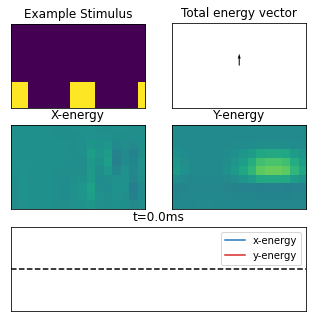

-1.3014364742011513e-19 1.3363452371085587e-17


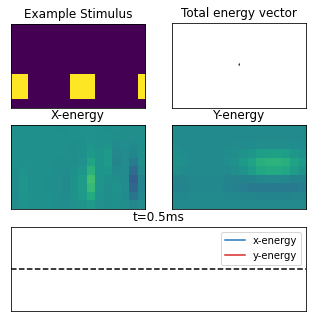

-1.2385736557039622e-19 -1.1961348386558622e-17


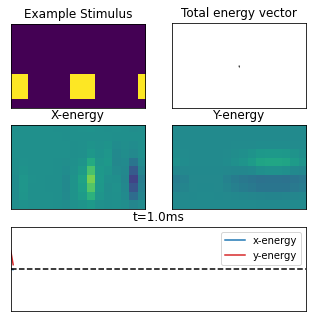

-8.078793223113831e-20 -3.2775648563356207e-17


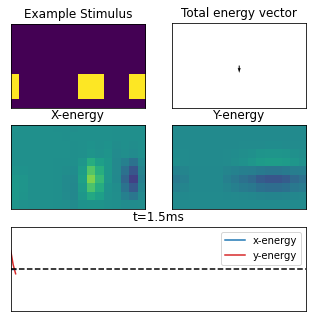

-5.603729728302944e-20 -4.4767508615783196e-17


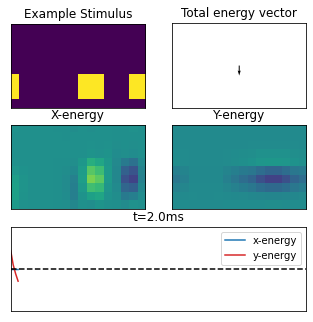

-1.2633485389993636e-19 -5.44213660494867e-17


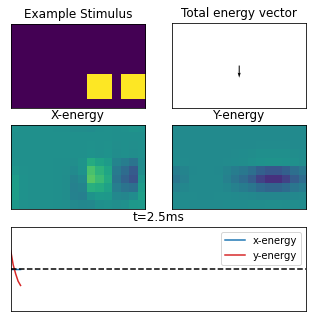

-1.6858916900407967e-19 -5.868867628876089e-17


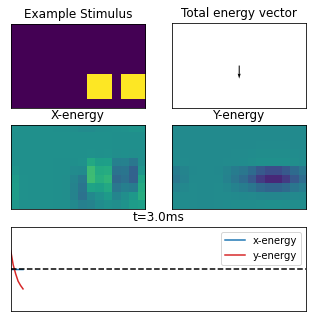

-1.0152405125578707e-19 -4.03022335140502e-17


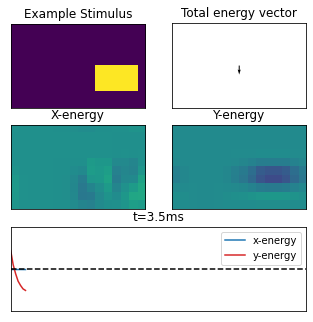

-9.991508479796912e-20 -2.3992899414554858e-17


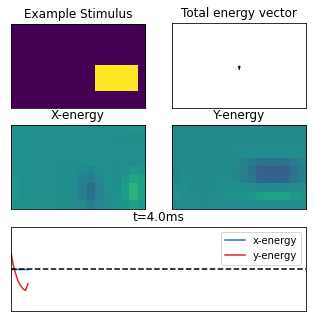

-7.753206411790828e-20 -1.0332194749340149e-17


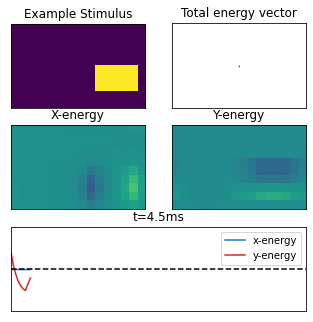

-6.981040398361127e-20 1.623297281640474e-17


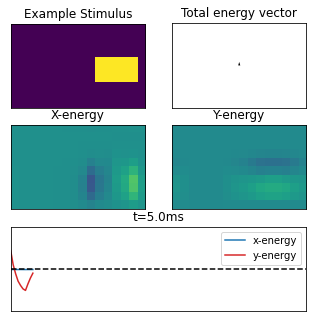

-1.7666560116776635e-20 3.630782488704339e-17


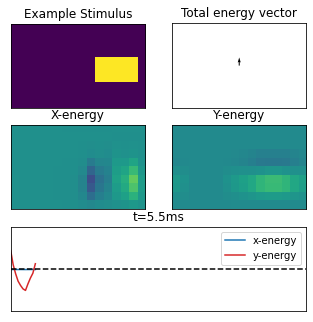

2.5701706077474436e-20 5.0734879015745986e-17


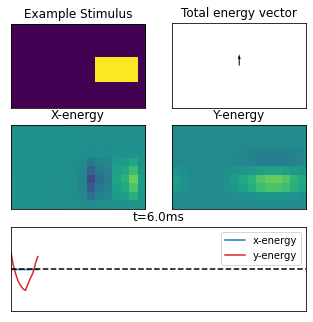

7.533235696240505e-20 6.027997394997946e-17


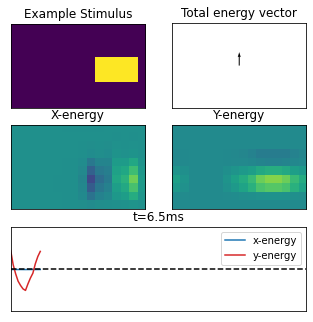

8.536047417207725e-20 6.588501819136034e-17


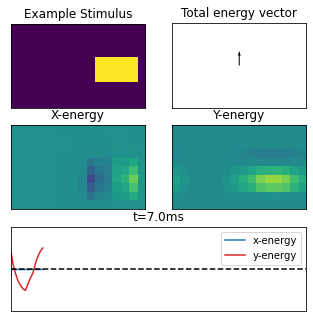

8.018711880205708e-20 6.849541694953633e-17


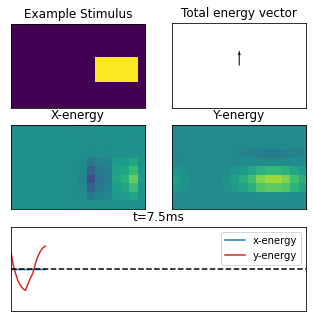

3.940493830634927e-20 8.532110443670894e-17


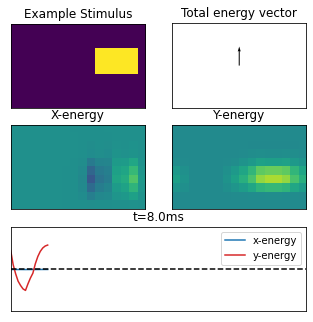

4.817911049385699e-20 9.775182307636737e-17


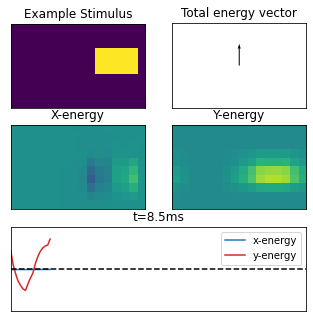

-9.28746085544418e-21 1.0589100104152435e-16


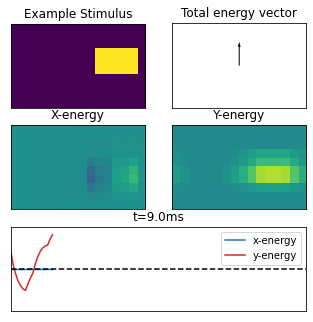

-9.51576459935271e-21 1.1434973635372258e-16


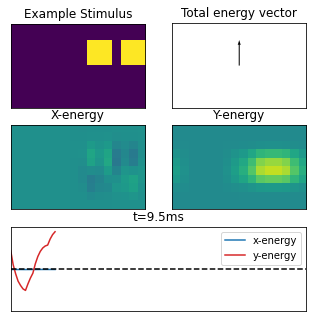

-9.114368900878391e-20 1.203954425032468e-16


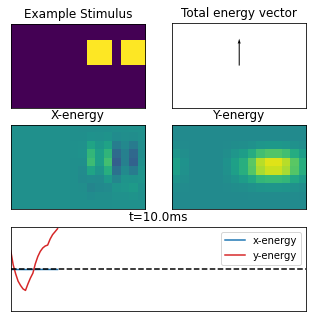

-1.1216384601119655e-19 1.1782765800995658e-16


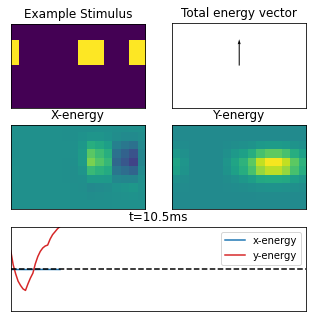

-1.1862333686973892e-19 1.149246230585832e-16


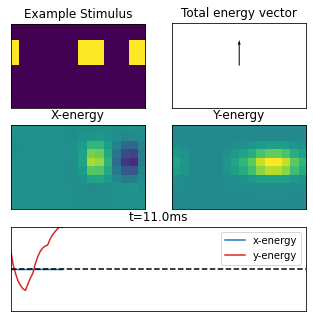

-1.08797200040113e-19 1.0439793874799043e-16


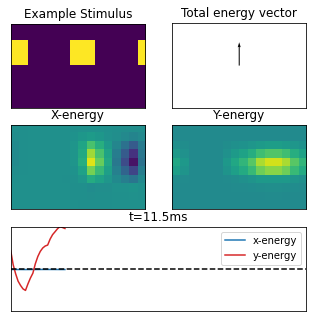

-1.3026316299007796e-19 9.546637948800384e-17


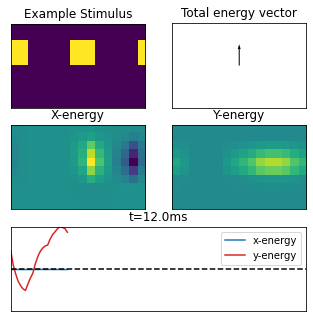

-1.6512890912552144e-19 9.585806646055496e-17


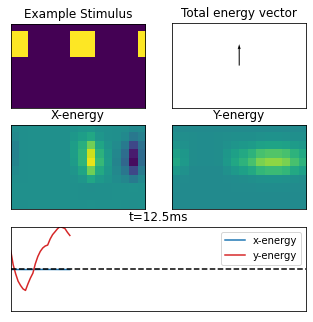

-1.721721447666299e-19 8.469886469503602e-17


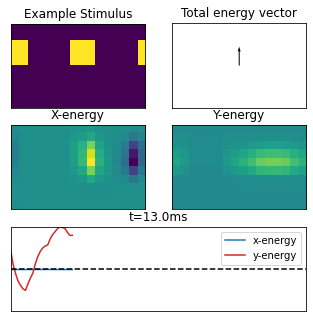

-8.355882869059457e-20 7.42409657813912e-17


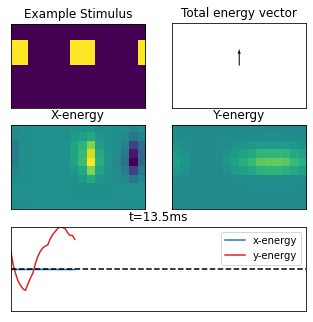

-1.1299590270868882e-19 6.051761295583192e-17


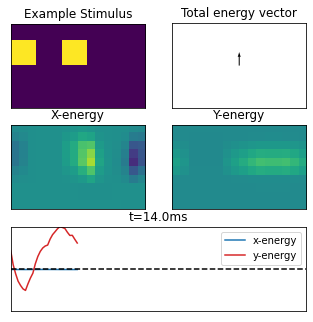

-4.858653267147203e-20 4.920328231984615e-17


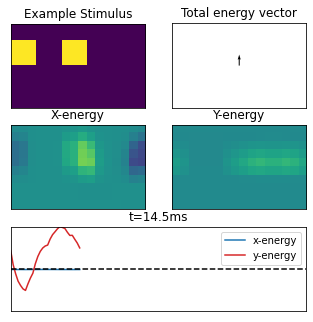

-6.725907588782706e-20 3.726401156766009e-17


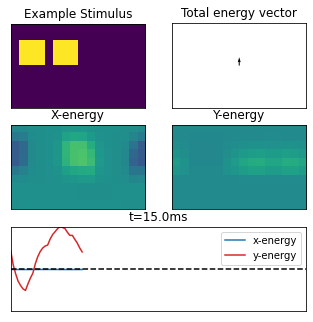

-9.401845921781777e-21 2.8277020735355904e-17


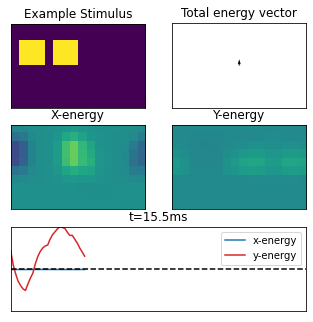

-7.74035465832101e-20 -6.686959304409148e-18


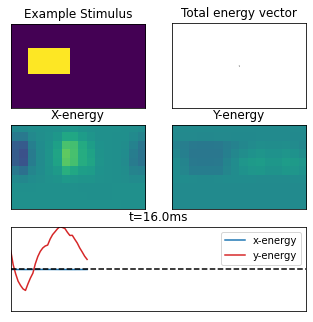

-4.436066086102558e-20 -3.27352401521751e-17


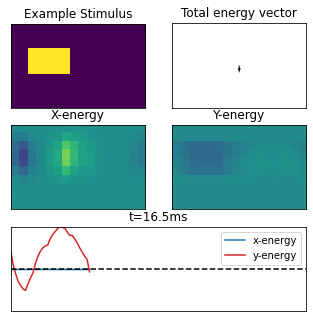

-4.077633277729971e-20 -5.131897676132485e-17


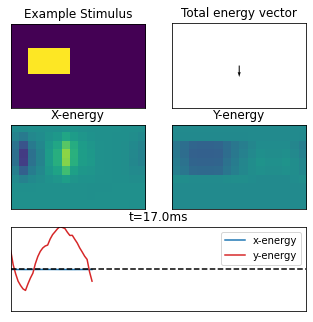

-6.357751547113198e-20 -7.166391976723885e-17


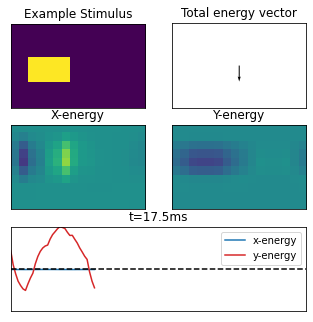

-1.2827088143272666e-20 -8.670767267044938e-17


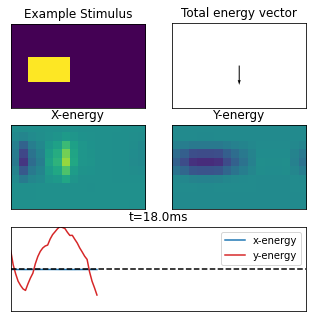

-1.6793741570877002e-19 -9.665867289103452e-17


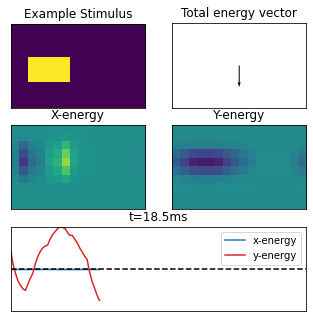

-7.024118231945687e-20 -1.022634441366639e-16


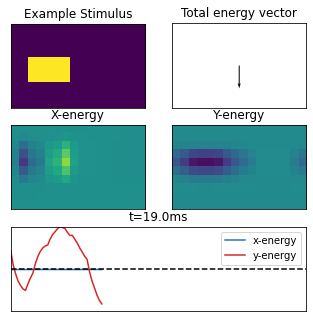

-1.1115053325158737e-19 -1.0415246164865093e-16


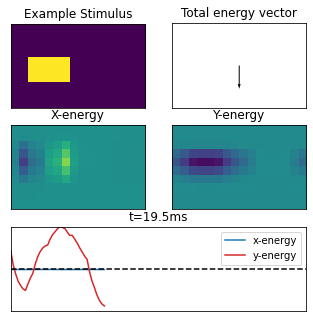

-1.164465122810051e-21 -1.0329405084418787e-16


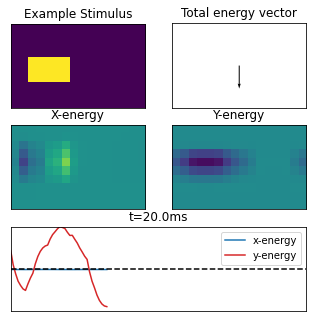

8.839838806988684e-20 -1.0863446703576397e-16


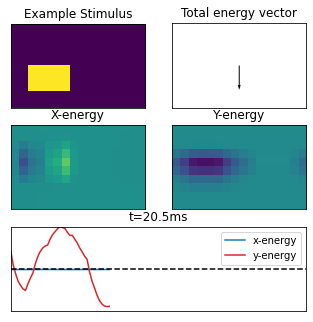

1.0108914812404024e-19 -1.1293508687925276e-16


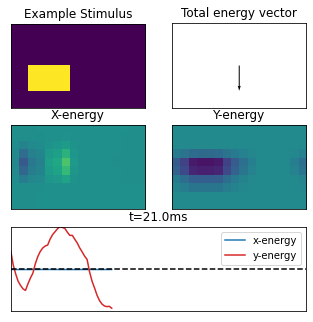

1.8324592855963456e-19 -1.1553341204337526e-16


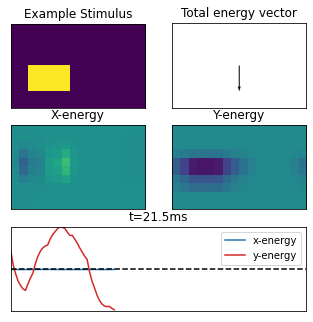

1.629652887844699e-19 -1.1592239866648988e-16


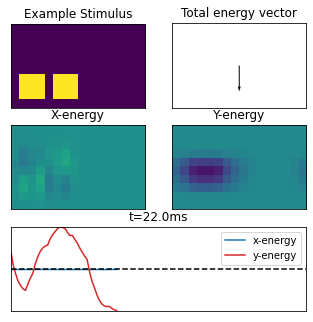

-1.2538054758257873e-21 -1.172655374688424e-16


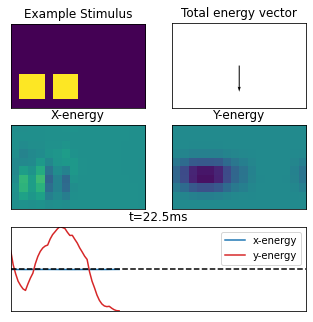

-2.213878469899141e-20 -1.1307998004324522e-16


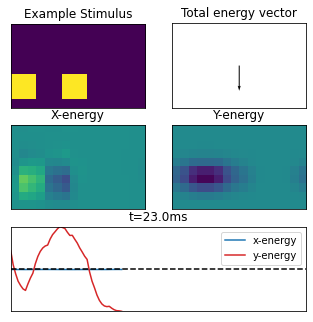

-1.272741061763804e-19 -1.0925717063865414e-16


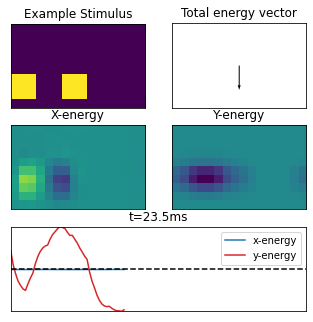

-6.475775357122884e-20 -9.933396272719397e-17


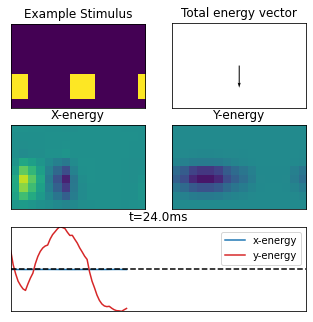

-8.552804549493369e-20 -9.099729152267016e-17


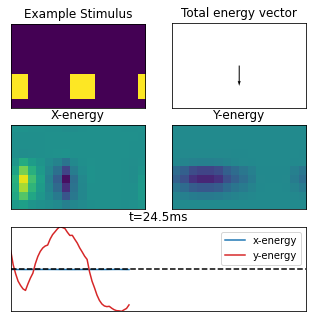

-9.510684868708603e-20 -9.166957981059316e-17


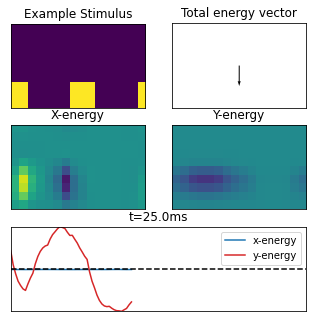

-1.220226401976624e-19 -8.110709075858046e-17


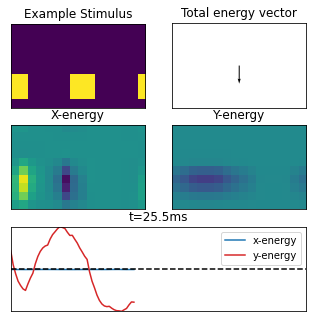

-5.48361882205434e-20 -7.119172377595526e-17


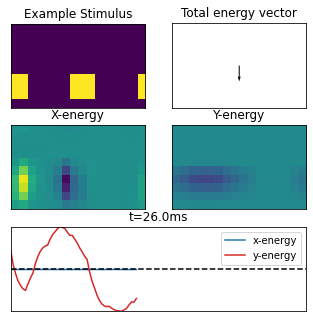

-1.097947587820663e-19 -5.82258223569611e-17


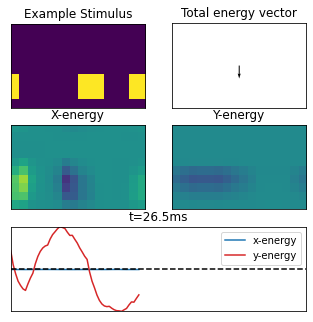

-4.3049374209403496e-20 -4.745844939138954e-17


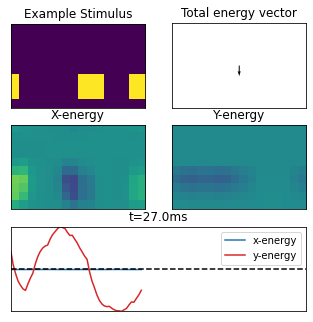

-6.30303613453223e-20 -3.6041888615022295e-17


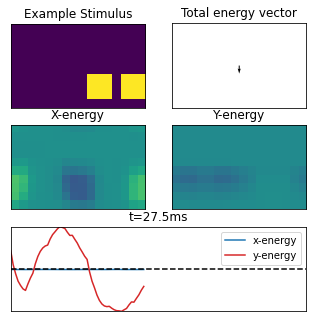

-1.9758449701747896e-20 -2.7456727209195947e-17


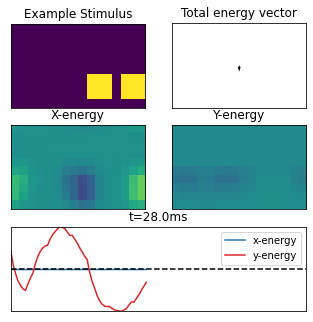

-5.579855389431846e-20 6.844837445351114e-18


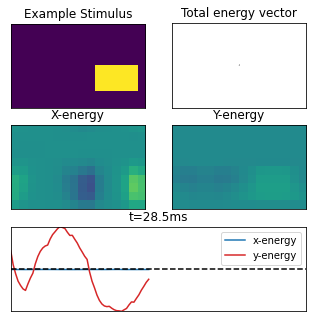

-3.2726169858264514e-20 3.2451464595321157e-17


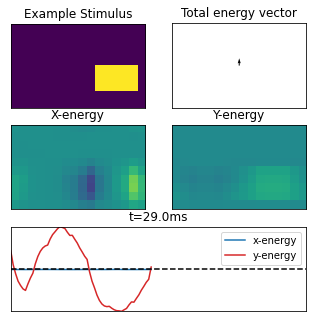

-2.008051215012799e-20 5.0953869378368794e-17


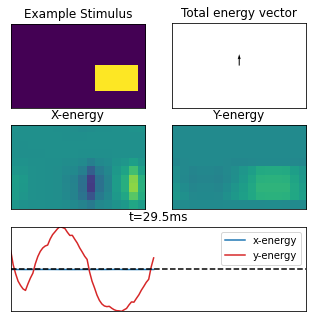

-8.235732649769869e-20 7.107746219016662e-17


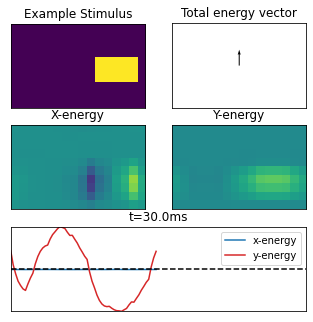

-3.58539013130409e-21 8.597503411186171e-17


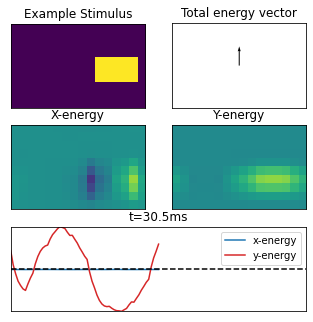

-1.5379735767324129e-19 9.581955154667632e-17


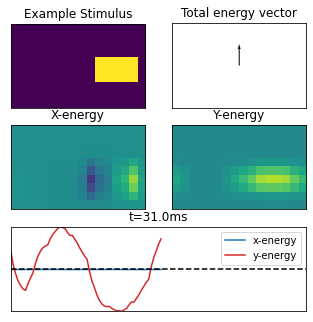

-8.692397901768941e-20 1.0153732988760956e-16


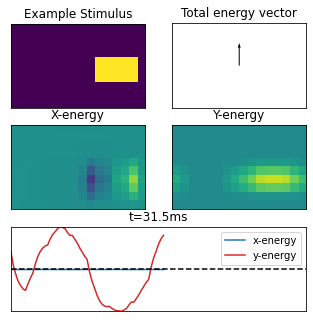

-1.1330018058141697e-19 1.0353372592826648e-16


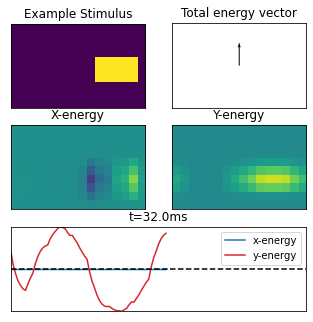

-1.3724178644231888e-20 1.0275557018369901e-16


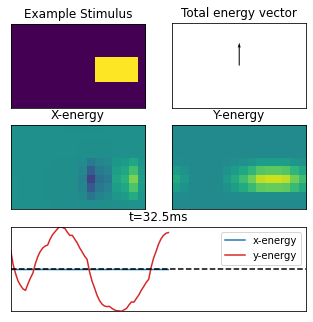

8.70720298070522e-20 1.0823775832135524e-16


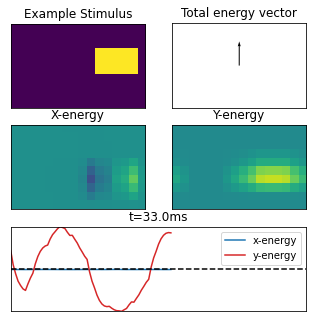

9.913503732446028e-20 1.126608884885973e-16


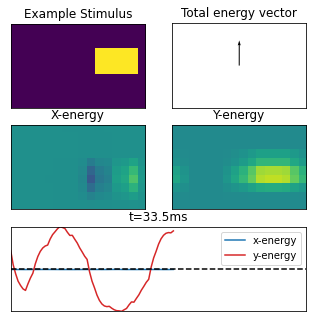

1.833528158044129e-19 1.152096502384567e-16


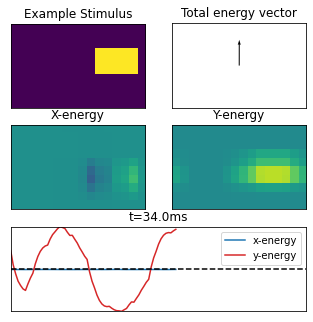

1.2657075708646596e-19 1.1566768762173523e-16


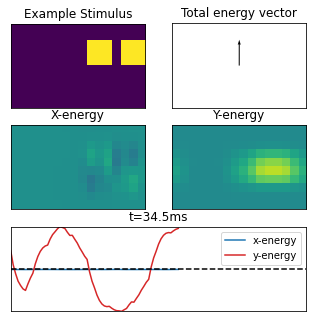

-2.781821324712903e-20 1.1711516214585224e-16


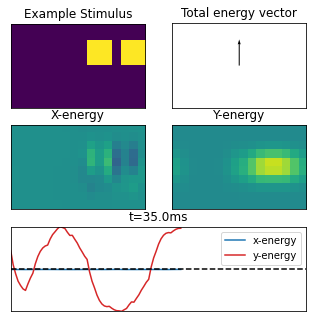

-8.866374502545443e-21 1.1293892140766235e-16


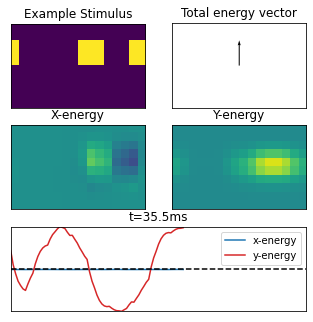

-1.2684140024313566e-19 1.0915046725990952e-16


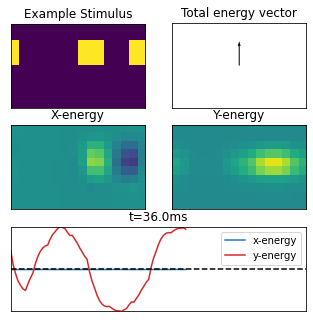

-7.1561042690839e-20 9.91550455252527e-17


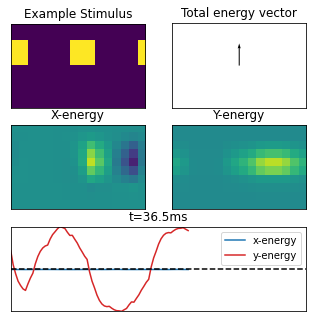

-7.3733083270084e-20 9.086331638798129e-17


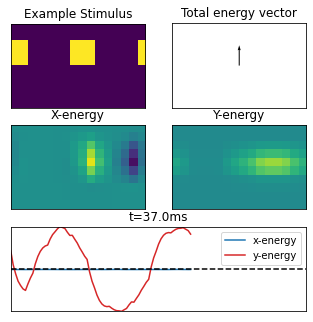

-1.020067539562708e-19 9.155152312015413e-17


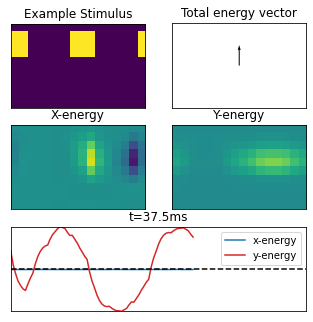

-1.325650748761092e-19 8.101349319139386e-17


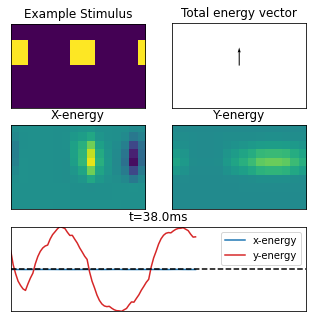

-6.533866700578834e-20 7.114576169201391e-17


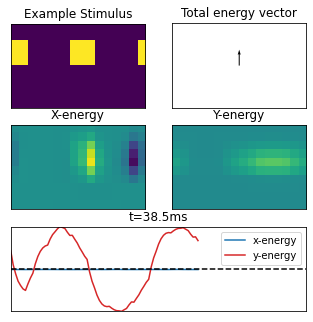

-1.3559485812971908e-19 5.817342301132119e-17


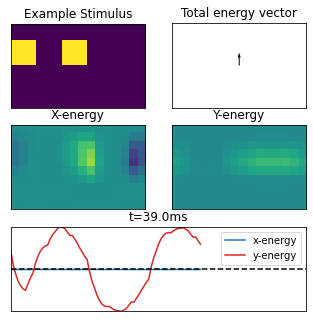

-4.7948700354069723e-20 4.739725329012786e-17


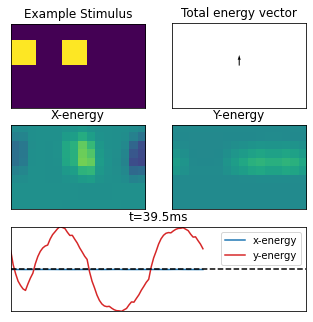

-7.282477433401542e-20 3.6032960311833733e-17


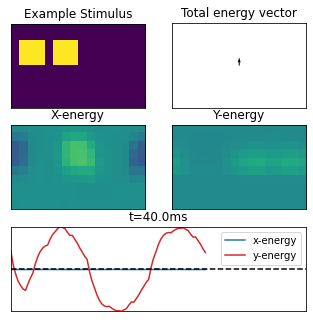

-1.0796774945348394e-20 2.7381155897960223e-17


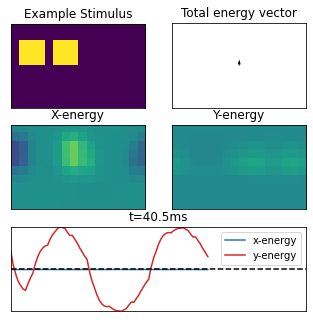

-5.748072906752161e-20 -6.7993028263783405e-18


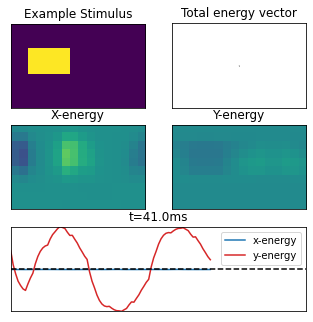

-4.5296571902117185e-20 -3.251387931457089e-17


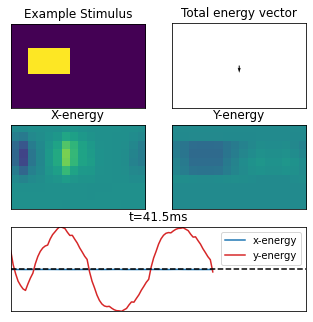

-1.9045476559276872e-20 -5.0910474310518003e-17


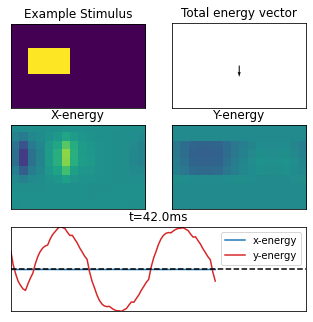

-7.225166418531261e-20 -7.10159309999775e-17


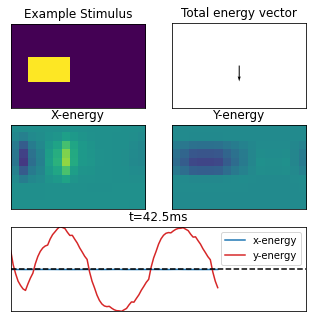

-2.1189657146191464e-20 -8.597196444622412e-17


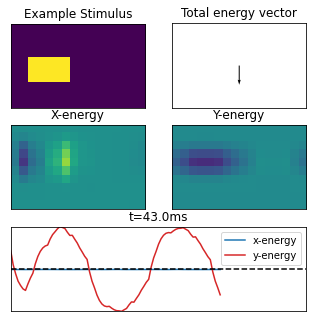

-1.529035825590292e-19 -9.591117710558907e-17


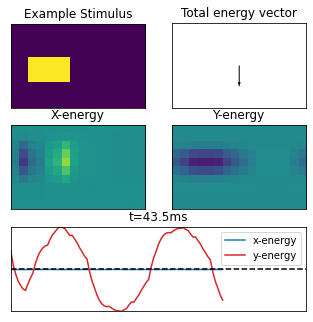

-7.616768462746461e-20 -1.0157461213273885e-16


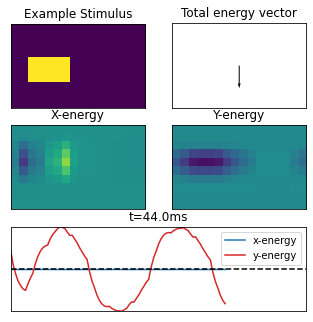

-1.2487026216490643e-19 -1.035693882766832e-16


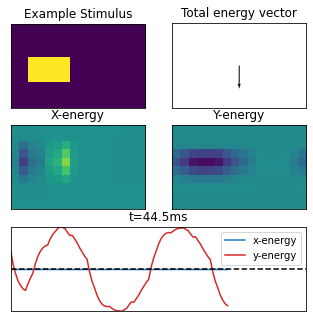

-9.120918535374289e-21 -1.0279639801977835e-16


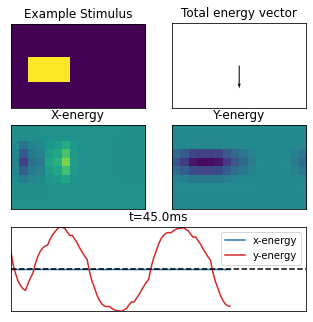

8.24620488557176e-20 -1.0821004239375683e-16


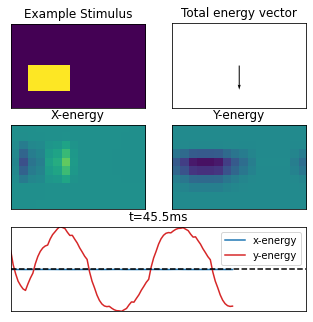

1.285966258041849e-19 -1.12586808674075e-16


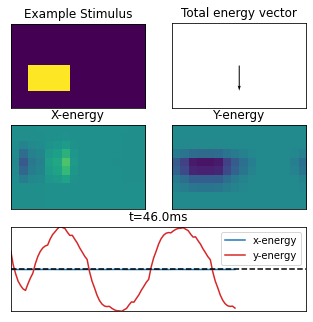

1.6780294473706117e-19 -1.1526850755136182e-16


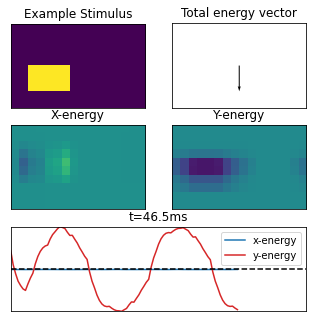

1.3298556858620884e-19 -1.157447015357573e-16


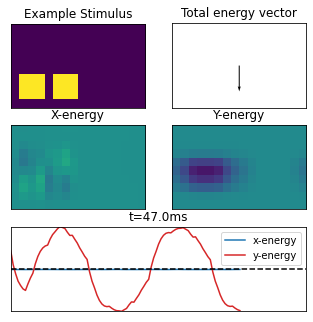

-3.2482477926162417e-20 -1.1717574269609706e-16


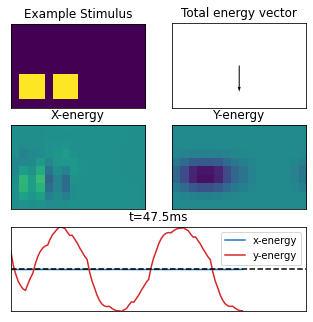

-3.5363528612639006e-20 -1.1303997782762612e-16


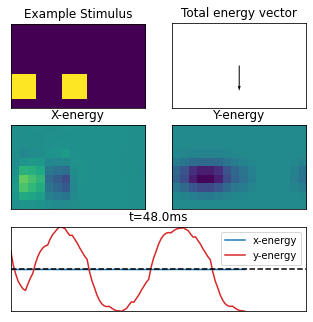

-1.1404746233226333e-19 -1.0922558911561238e-16


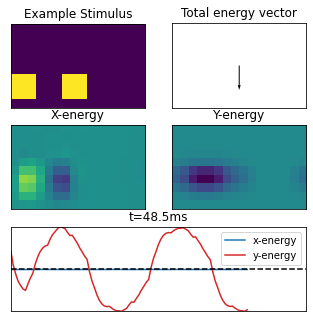

-5.752329655732541e-20 -9.930399712702531e-17


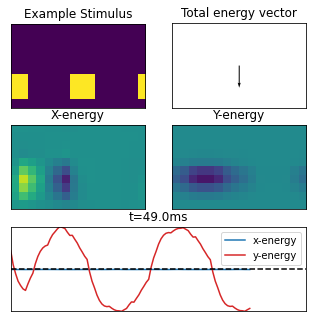

-8.157171171092645e-20 -9.096538199626224e-17


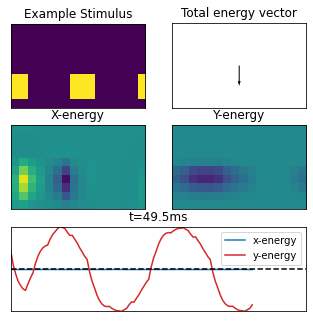

-1.0396181472108549e-19 -9.167972758479978e-17


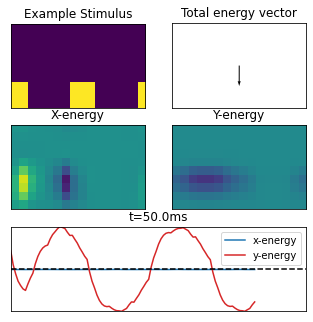

-1.3046951619178267e-19 -8.111014897455204e-17


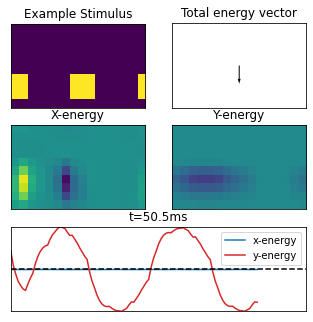

-6.069466502058824e-20 -7.120913100353992e-17


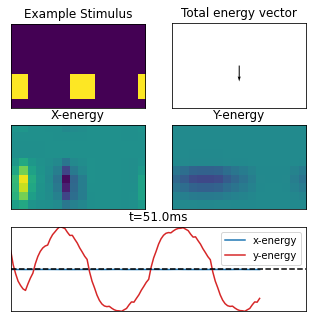

-1.1694651065941149e-19 -5.824670568182304e-17


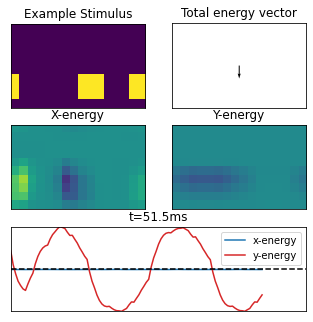

-5.4216609746902e-20 -4.746415550297478e-17


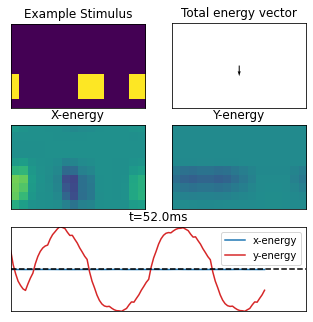

-6.992165472728986e-20 -3.605749238853878e-17


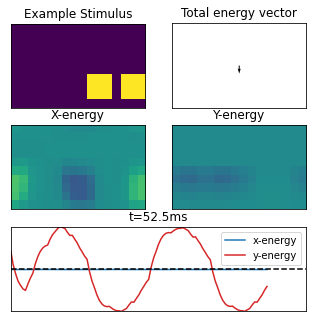

-1.2985805038893412e-20 -2.7435543165407252e-17


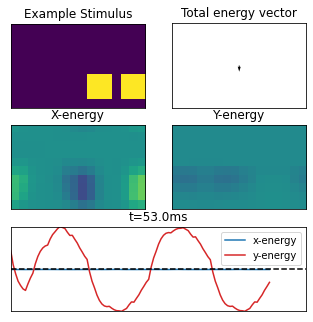

-5.13840460614878e-20 6.871773987462838e-18


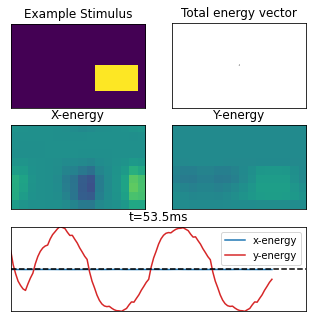

-4.341693320706114e-20 3.2528101289336455e-17


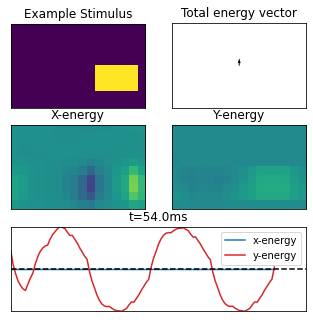

-2.064855258640464e-20 5.093640762471837e-17


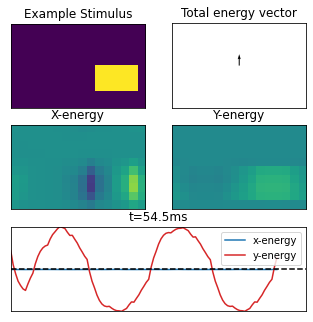

-7.163045154528529e-20 7.112595690727316e-17


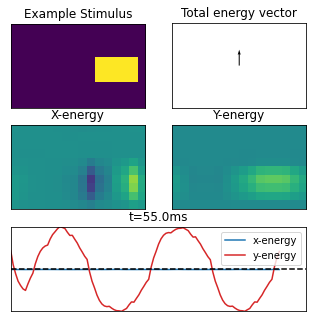

-2.1189657146191464e-20 8.594514896813427e-17


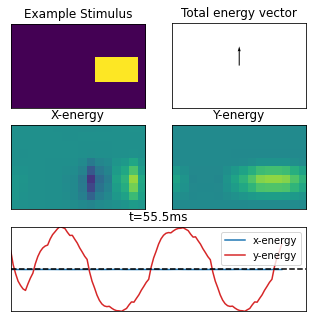

-1.529035825590292e-19 9.581519791901345e-17


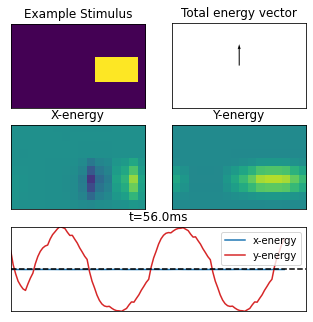

-7.616768462746461e-20 1.0159195164137321e-16


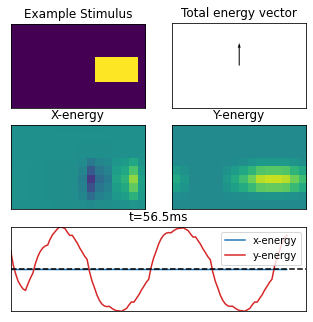

-1.2487026216490643e-19 1.035066153922672e-16


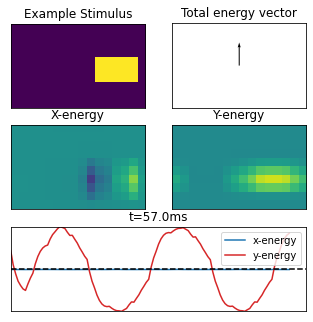

-9.120918535374289e-21 1.0277875857900818e-16


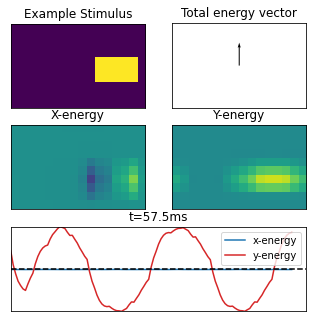

8.24620488557176e-20 1.0820676303581447e-16


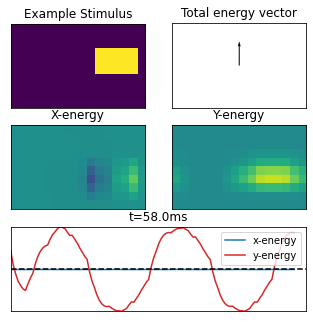

1.285966258041849e-19 1.1268592042230703e-16


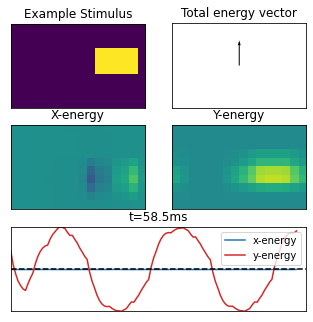

1.6780294473706117e-19 1.1525247307039337e-16


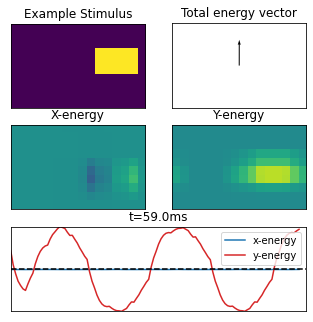

1.3298556858620884e-19 1.1573289434050862e-16


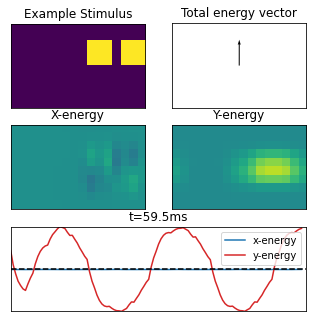

In [11]:
combined_img_files = []
process_combined = True
step_size = 1
x_energy_min = np.min(motion_contrast_x)
x_energy_max = np.max(motion_contrast_x)
y_energy_min = np.min(motion_contrast_y)
y_energy_max = np.max(motion_contrast_y)
matplotlib.rc ('figure', figsize= (5.3, 5.3))

for i in range(0, stim.shape[0], step_size):
        
    fig = plt.figure()
    gs = GridSpec(3, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[2,:])
    dir_ax = fig.add_subplot(gs[0,1])
    ax_y_energy = fig.add_subplot(gs[1,1])
    
    ax0.imshow(np.transpose(stim)[:,:,i])
    ax0.set_title("Example Stimulus")
    ax0.set_yticks([])
    ax0.set_xticks([])
    ax1.imshow(np.transpose(motion_contrast_x)[:,:,i],
               vmin=x_energy_min,
               vmax=x_energy_max)
    ax1.set_title("X-energy")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax_y_energy.imshow(np.transpose(motion_contrast_y)[:,:,i],
                       vmin=y_energy_min,
                       vmax=y_energy_max)
    ax_y_energy.set_title("Y-energy")
    ax_y_energy.set_yticks([])
    ax_y_energy.set_xticks([])
    
    ax2.plot(motion_contrast_per_frame_x[:i], color='tab:blue', label="x-energy")
    ax2.plot(motion_contrast_per_frame_y[:i], color='tab:red', label="y-energy")
    ax2.axhline(y=0.0, color='black', linestyle='--')
    ax2.set_xlim([0, motion_contrast_per_frame_x.shape[0]])
    y_max = max(np.max(motion_contrast_per_frame_x), np.max(motion_contrast_per_frame_y))
    y_min = min(np.min(motion_contrast_per_frame_x), np.min(motion_contrast_per_frame_y))
    ax2.set_ylim([y_min, y_max])
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_title("t="+str(i/2)+"ms")
    ax2.legend(loc='upper right')
    
    dir_ax.set_title("Total energy vector")
    dir_ax.set_yticks([])
    dir_ax.set_xticks([])
    x_max = max(-np.min(motion_contrast_per_frame_x), 
                np.max(motion_contrast_per_frame_x))
    y_max = max(-np.min(motion_contrast_per_frame_y), 
                np.max(motion_contrast_per_frame_y))
    norm = np.sqrt(x_max * x_max + y_max * y_max)
    dir_ax.set_xlim([-0.2, 0.2])
    dir_ax.set_ylim([-0.2, 0.2])
    dir_ax.quiver(0, 0,
                  motion_contrast_per_frame_x[i] / norm, 
                  motion_contrast_per_frame_y[i] / norm,
                  scale = 5)
    print(motion_contrast_per_frame_x[i], 
          motion_contrast_per_frame_y[i])
    
    combined_filename = "comb" + str(i/2) + ".png"
    plt.savefig(combined_filename)
    combined_img_files.append(imageio.imread(combined_filename))
    plt.show()

if process_combined:
    imageio.mimsave('comb_movie.gif', combined_img_files)
